**PROJECT OVERVIEW**

This project focuses on classifying fashion product images into their respective categories using the Fashion Product Images dataset. The task involves analyzing the dataset, preprocessing images, addressing class imbalance, and training a deep learning model (MobileNetV2) for classification. 

The key objectives are:

1. Data Analysis: Understanding the dataset structure and challenges.

2. Model Development: Fine-tuning a pre-trained MobileNetV2 model.

3. Performance Evaluation: Assessing metrics like accuracy, precision, recall, and F1-score.

Following block of code loads data from local directory, checks for bad lines in data, and prints data information.

In [12]:
import os
import pandas as pd

# Define the working directory
data_directory = "D:/Jupyter_projects/Hey-Savi_assignment/fashion-dataset"

if os.path.exists(data_directory):
    print(f"Data directory '{data_directory}' found.")
    print("Contents of the data directory:", os.listdir(data_directory))
else:
    raise FileNotFoundError(f"Data directory '{data_directory}' not found. Please check the path.")

# Load the styles CSV file with error handling
styles_path = os.path.join(data_directory, 'styles.csv')
try:
    data = pd.read_csv(styles_path, on_bad_lines='skip')
    print("\nDataset loaded successfully after skipping problematic rows.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Inspect the structure of the dataset
print("\nDataset Information:")
data.info()

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
data.head()


Data directory 'D:/Jupyter_projects/Hey-Savi_assignment/fashion-dataset' found.
Contents of the data directory: ['images', 'images.csv', 'styles', 'styles.csv']

Dataset loaded successfully after skipping problematic rows.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


**DATASET ANALYSIS**

To understand how product category varies across the dataset, distribution of article type class in plotted. 

Class Distribution of 'articleType':
articleType
Tshirts                7067
Shirts                 3217
Casual Shoes           2845
Watches                2542
Sports Shoes           2036
                       ... 
Cushion Covers            1
Mens Grooming Kit         1
Body Wash and Scrub       1
Suits                     1
Ipad                      1
Name: count, Length: 143, dtype: int64


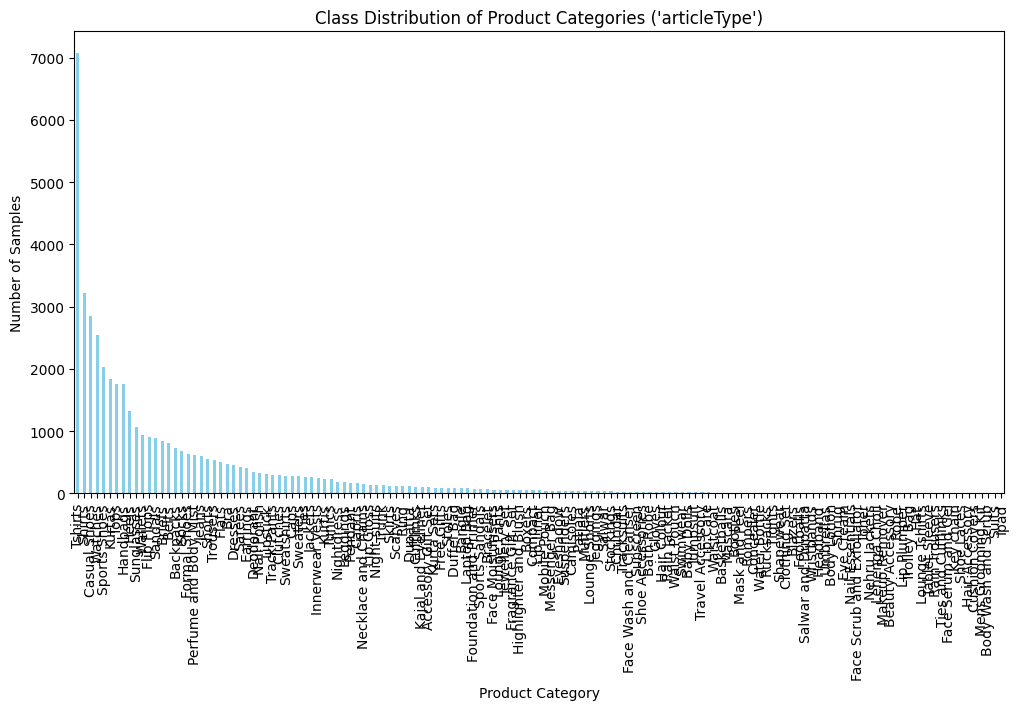

In [13]:
import matplotlib.pyplot as plt

# Count the occurrences of each class in 'articleType'
class_distribution = data['articleType'].value_counts()

# Display the class distribution
print("Class Distribution of 'articleType':")
print(class_distribution)

# Plot the class distribution
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title("Class Distribution of Product Categories ('articleType')")
plt.xlabel("Product Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()


From above graph, it can be seen that data is highly imbalanced across the dataset. Certain categories like Tshirts and casual shoes have significantly more images than some other items like ipad, travel accessory. Also, we need to perform data validation checks to identify problems in the dataset before proceeding with ML pipeline. 

**DATA VALIDATION**

I have performed following data validation steps to ensure quality of data:

1. Removing duplicates
2. Removing rows which do not have value in the target variable i.e. in articleType column.
3. We will create additional column for image path in the dataframe. Then we can check if all images have corresponding metadata in the styles.csv folder. 
4. We will also check if any images are corrupt or if any images have no data values. 

In [14]:
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates if any
df = data.drop_duplicates()

Number of duplicate rows: 0


In [15]:
df = data.dropna(subset=['articleType'])
df = data.dropna(subset=['masterCategory'])


In [16]:
import numpy as np

# Add a column for image file paths
data['image_path'] = data['id'].apply(lambda x: os.path.join(data_directory, 'images', f"{x}.jpg"))

# Check if all image files exist
data['image_exists'] = data['image_path'].apply(lambda x: os.path.exists(x))
missing_images = data[~data['image_exists']]
print(f"Number of missing images: {len(missing_images)}")

# Filter out rows with missing images
data = data[data['image_exists']]

# Display the updated dataframe
print("\nUpdated dataset after filtering missing images:")
print(data[['id', 'articleType', 'image_path']].head())

# Get unique classes for 'articleType'
classes = data['articleType'].unique()
print(f"\nNumber of unique product categories (classes): {len(classes)}")
print(f"Classes: {classes}")


Number of missing images: 5

Updated dataset after filtering missing images:
      id  articleType                                         image_path
0  15970       Shirts  D:/Jupyter_projects/Hey-Savi_assignment/fashio...
1  39386        Jeans  D:/Jupyter_projects/Hey-Savi_assignment/fashio...
2  59263      Watches  D:/Jupyter_projects/Hey-Savi_assignment/fashio...
3  21379  Track Pants  D:/Jupyter_projects/Hey-Savi_assignment/fashio...
4  53759      Tshirts  D:/Jupyter_projects/Hey-Savi_assignment/fashio...

Number of unique product categories (classes): 142
Classes: ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'Kurtas' 'Waistcoat' 'Sports Shoes' 'Shorts' 'Briefs' 'Sarees'
 'Perfume and Body Mist' 'Heels' 'Sunglasses' 'Innerwear Vests' 'Pendant'
 'Nail Polish' 'Laptop Bag' 'Scarves' 'Rain Jacket' 'Dresses'
 '

As seen above, 5 images are missing in the images folder. So, removed rows which does not have corresponding images.

In [21]:
from PIL import Image
corrupt_count = 0
corrupt_images = []

for img_path in data["image_path"]:
    if not os.path.exists(img_path):  # Check if file exists
        print(f"File not found: {img_path}")
        corrupt_images.append(img_path)
        corrupt_count += 1
        continue
        
    try:
        with Image.open(img_path) as img:
            img_array = np.array(img)

            # Check if image is empty (all pixel values are the same or zero)
        if np.all(img_array == 0):  
            print(f"Empty Image (No Data): {img_path}")
            corrupt_images.append(img_path)
            corrupt_count += 1

    except Exception as e:
        print(f"Corrupt Image: {img_path} | Error: {e}")
        corrupt_images.append(img_path)
        corrupt_count += 1

print(f"\nTotal Corrupt/No-Data Images: {corrupt_count}")
if corrupt_count > 0:
    print("List of Corrupt/No-Data Images:", corrupt_images)


Total Corrupt/No-Data Images: 0


**DATA PRE-PROCESSING**  (Updated after the interview)

As seen for some of the classes, number of items are very less. This makes it difficult to learn from them. Thus, identified classes with less than 100 entries and added them in their corresponding 'MasterCategory'. And after that they are again checked for less than 100 images to move to the 'other' category.

Updated Class Distribution (after grouping minority classes):
articleType
Tshirts                  7066
Shirts                   3215
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Accessories               823
Belts                     813
Backpacks                 724
Apparel                   706
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     608
Personal Care             554
Shorts                    547
Trousers                  530
Flats                     500
Bra                       477
Dresses                   464
Sarees                    427
Earrings                  416
Deodorant                 

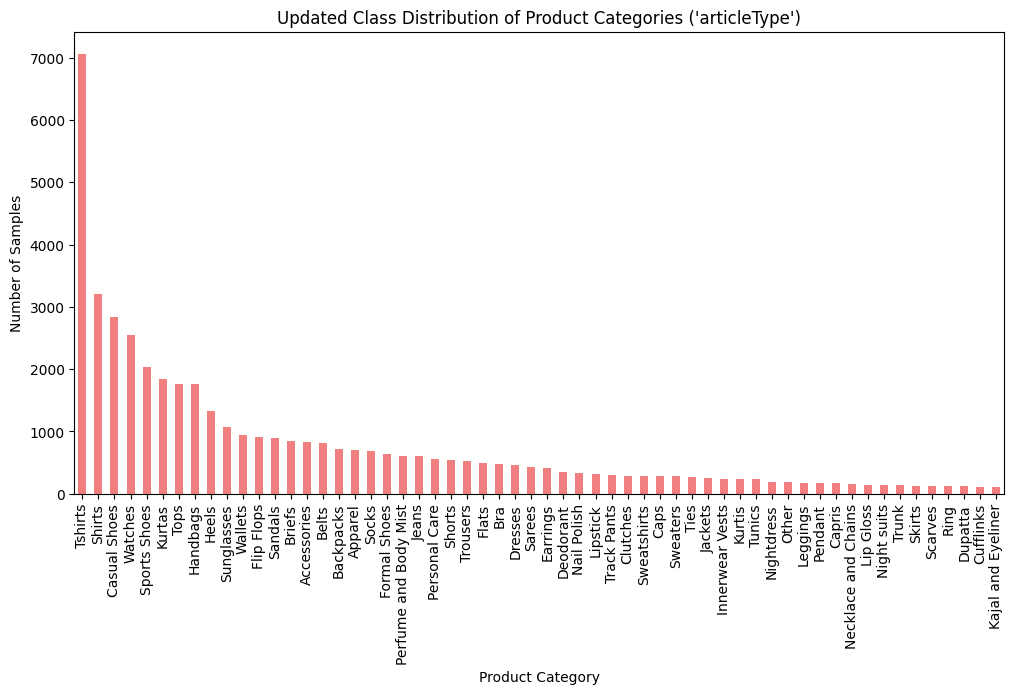

In [18]:
# Analyze the class distribution to identify classes with fewer than 100 images
class_counts = data['articleType'].value_counts()

# Identify classes with fewer than 100 images
minority_classes = class_counts[class_counts < 100].index

# Relabel these minority classes as "Other"



# Update in how we group minority. Instead of using other category. We can use master category in its place first
data['articleType'] = data.apply(lambda row: row['masterCategory'] if row['articleType'] in minority_classes else row['articleType'], axis=1)

# Analyze the class distribution again to ensure we dont have less than 100 images even after using master category.
class_counts = data['articleType'].value_counts()

# Identify classes with fewer than 100 images
minority_classes = class_counts[class_counts < 100].index

data['articleType'] = data['articleType'].apply(lambda x: 'Other' if x in minority_classes else x)

# Display the updated class distribution
updated_class_distribution = data['articleType'].value_counts()
print("Updated Class Distribution (after grouping minority classes):")
print(updated_class_distribution)

# Plot the updated class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
updated_class_distribution.plot(kind='bar', color='lightcoral')
plt.title("Updated Class Distribution of Product Categories ('articleType')")
plt.xlabel("Product Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()


As seen from above graph, data is a bit better than the initial distribution. However, class imbalance is still there.   

Also because of updates in the minority grouping. Now 'Other' category is not dominating with 2000+ images as done previously. 

Now, spliting the dataset for training, testing and validation. 

In [19]:
from sklearn.model_selection import train_test_split

target_column = 'articleType'
# Retry splitting the dataset after grouping minority classes
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data[target_column], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data[target_column], random_state=42)

# Display the sizes of each split
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 31093
Validation set size: 6663
Test set size: 6663


Selected MobileNetV2 model for CNN implementation. It requires input image of size (224, 224). Thus, we will resize the image. And, performed Data augmentation using ImageDataGenerator during training.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
image_size = (224, 224)  # MobileNetV2 requires input size of 224x224
batch_size = 32

# Create ImageDataGenerator objects for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for testing

# Generate data from the dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='articleType',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='articleType',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='articleType',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure order is preserved for evaluation
)

# Display class indices (mapping of labels to numerical values)
print("\nClass indices:")
print(train_generator.class_indices)


Found 31093 validated image filenames belonging to 58 classes.
Found 6663 validated image filenames belonging to 58 classes.
Found 6663 validated image filenames belonging to 58 classes.

Class indices:
{'Accessories': 0, 'Apparel': 1, 'Backpacks': 2, 'Belts': 3, 'Bra': 4, 'Briefs': 5, 'Capris': 6, 'Caps': 7, 'Casual Shoes': 8, 'Clutches': 9, 'Cufflinks': 10, 'Deodorant': 11, 'Dresses': 12, 'Dupatta': 13, 'Earrings': 14, 'Flats': 15, 'Flip Flops': 16, 'Formal Shoes': 17, 'Handbags': 18, 'Heels': 19, 'Innerwear Vests': 20, 'Jackets': 21, 'Jeans': 22, 'Kajal and Eyeliner': 23, 'Kurtas': 24, 'Kurtis': 25, 'Leggings': 26, 'Lip Gloss': 27, 'Lipstick': 28, 'Nail Polish': 29, 'Necklace and Chains': 30, 'Night suits': 31, 'Nightdress': 32, 'Other': 33, 'Pendant': 34, 'Perfume and Body Mist': 35, 'Personal Care': 36, 'Ring': 37, 'Sandals': 38, 'Sarees': 39, 'Scarves': 40, 'Shirts': 41, 'Shorts': 42, 'Skirts': 43, 'Socks': 44, 'Sports Shoes': 45, 'Sunglasses': 46, 'Sweaters': 47, 'Sweatshirts': 

**MODEL DEVELOPMENT**

In the following code, I downloaded the model with it's trained parameters. Used pretrained model thus freezing base model. And at the end, added custom layers as per our target output classes. As the problem is of multiclass classification, softmax function is used. 

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pretrained features
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)  # Regularization with dropout
output_layer = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Final classification layer

# Create the complete model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with appropriate optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,328,439 (8.88 MB)

 Trainable params: 70,455 (275.21 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

As we can see, the main advantage of using pretrained model is we only have 70,455 parameters to train out of 2,328,439 parameters. As we have imbalanced data, there is a high probability of overfitting. To address this we will also use Early stopping on validation loss. Epoch is set to 10 for seeing results. And model is saved for deployment.  

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust based on time constraints (10 is a good starting point)
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Save the trained model
model.save('fashion_category_classifier.h5')
print("\nModel saved as 'fashion_category_classifier.h5'")


c:\Users\svaid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 971s 996ms/step - accuracy: 0.5862 - loss: 1.5401 - val_accuracy: 0.7824 - val_loss: 0.6499
Epoch 2/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 803s 811ms/step - accuracy: 0.7660 - loss: 0.7306 - val_accuracy: 0.8091 - val_loss: 0.5629
Epoch 3/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 770s 792ms/step - accuracy: 0.7819 - loss: 0.6756 - val_accuracy: 0.8210 - val_loss: 0.5403
Epoch 4/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 771s 794ms/step - accuracy: 0.7841 - loss: 0.6657 - val_accuracy: 0.8199 - val_loss: 0.5404
Epoch 5/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 771s 793ms/step - accuracy: 0.7962 - loss: 0.6284 - val_accuracy: 0.8250 - val_loss: 0.5297
Epoch 6/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 770s 792ms/step - accuracy: 0.7956 - loss: 0.6281 - val_accuracy: 0.8265 - val_loss: 0.5350
Epoch 7/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 773s 795ms/step - accuracy: 0.8027 - loss: 0.6181 - val_accuracy: 0.8370 - val_loss: 0.5141
Epoch 8/10
972/972 ━━━━━━━━━━━━━━━━━━━━ 773s 795ms/step - accuracy: 0.8001 -


Model saved as 'fashion_category_classifier.h5'


**MODEL EVALUATION**

For evaluating the model, accuracy alone is not enough as it can be misleading across different classes. Thus, we have used following metrics to evaluate the model better:
1. Precision
2. Recall
3. F1 score 

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Function to calculate accuracy per class
def calculate_accuracy_per_class(conf_matrix):
    accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    return accuracy_per_class

# Function to calculate precision per class
def calculate_precision_per_class(conf_matrix):
    precision_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
    return precision_per_class

# Function to calculate recall per class
def calculate_recall_per_class(conf_matrix):
    recall_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    return recall_per_class

# Function to calculate F1-score per class
def calculate_f1_score_per_class(precision, recall):
    f1_score_per_class = 2 * (precision * recall) / (precision + recall)
    return f1_score_per_class


In [15]:
# Generate predictions for the test set
test_generator.reset()  # Reset generator to ensure order matches test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = test_generator.classes  # True labels from the generator
class_labels = list(test_generator.class_indices.keys())  # Class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Calculate metrics per class
accuracy_per_class = calculate_accuracy_per_class(conf_matrix)
precision_per_class = calculate_precision_per_class(conf_matrix)
recall_per_class = calculate_recall_per_class(conf_matrix)
f1_score_per_class = calculate_f1_score_per_class(precision_per_class, recall_per_class)

# Display metrics per class
print("\nMetrics Per Class:")
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f"Accuracy: {accuracy_per_class[i]:.2f}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print(f"F1-Score: {f1_score_per_class[i]:.2f}\n")

# Generate a classification report for overall metrics
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


209/209 ━━━━━━━━━━━━━━━━━━━━ 115s 549ms/step

Metrics Per Class:
Class: Backpacks
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-Score: 0.93

Class: Belts
Accuracy: 0.98
Precision: 0.99
Recall: 0.98
F1-Score: 0.98

Class: Bra
Accuracy: 1.00
Precision: 0.97
Recall: 1.00
F1-Score: 0.99

Class: Briefs
Accuracy: 0.95
Precision: 0.98
Recall: 0.95
F1-Score: 0.96

Class: Capris
Accuracy: 0.38
Precision: 0.48
Recall: 0.38
F1-Score: 0.43

Class: Caps
Accuracy: 0.84
Precision: 1.00
Recall: 0.84
F1-Score: 0.91

Class: Casual Shoes
Accuracy: 0.86
Precision: 0.71
Recall: 0.86
F1-Score: 0.77

Class: Clutches
Accuracy: 0.72
Precision: 0.50
Recall: 0.72
F1-Score: 0.59

Class: Cufflinks
Accuracy: 0.88
Precision: 0.93
Recall: 0.88
F1-Score: 0.90

Class: Deodorant
Accuracy: 0.98
Precision: 0.93
Recall: 0.98
F1-Score: 0.95

Class: Dresses
Accuracy: 0.35
Precision: 0.60
Recall: 0.35
F1-Score: 0.44

Class: Dupatta
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1-Score: 0.83

Class: Earrings
Accuracy: 0.86
Pre

The classification report shows that while some classes perform exceptionally well, others struggle due to limited representation or inherent difficulty in classification.

Challenges Encountered
1. Class Imbalance:
    Despite grouping minority classes into "Other," imbalance persisted among larger categories.
    Augmentation helped but did not fully resolve this issue.

2. Limited Representation:
    Certain categories like Tunics had very few samples even after preprocessing, leading to poor performance.

Proposed Improvements:

1. Use class weights during training to prioritize underrepresented classes.
2. Experiment with alternative architectures like EfficientNetB0 or ResNet50.
3. Generate synthetic samples for minority classes using GANs or advanced augmentation techniques like Albumentations.
4. Perform hyperparameter optimization (e.g., learning rate tuning) using tools like Optuna or GridSearchCV.

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = tf.keras.models.load_model('fashion_category_classifier.h5')

# Class indices (mapping of numerical labels to class names)
class_indices = train_generator.class_indices
reverse_class_indices = {v: k for k, v in class_indices.items()}  # Reverse mapping

def predict_image(image_path):
    # Load and preprocess the image
    image_size = (224, 224)  # MobileNetV2 input size
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = reverse_class_indices[predicted_class_index]

    print(f"Predicted Class: {predicted_class_name}")
    return predicted_class_name

# Example usage
image_path = input("Enter image path here:")  # Replace with your image path
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
Predicted Class: Tshirts


'Tshirts'